In [55]:
# Please Run all cells together

import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                # linear algebra
import pandas as pd               # data frames
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
import xlrd
import scipy.stats # statistics
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import datasets
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer 
from sagemaker.xgboost.estimator import XGBoost
from collections import Counter, defaultdict

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")
bucket_name = 'tragicbytes' 
print(bucket_name)
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)
    
path = os.getcwd()

filepath = os.path.join(path, "race.csv")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.
tragicbytes
S3 bucket created successfully


In [56]:
print(filepath)
try:
    df = pd.read_csv(filepath)
except Exception as e:
    print('Data load error: ',e)
main_data = df.copy()

print(df.head())
  

/home/ec2-user/SageMaker/TragicBytes_hack/race.csv
       Date State  Cases_Total  Cases_White  Cases_Black  Cases_LatinX  \
0  20200809    AK       4473.0        988.0        117.0           NaN   
1  20200809    AL     101334.0      30405.0      26613.0           NaN   
2  20200809    AR      49383.0      25178.0      10569.0           NaN   
3  20200809    AS          NaN          NaN          NaN           NaN   
4  20200809    AZ     186923.0      33934.0       4539.0       47028.0   

   Cases_Asian  Cases_AIAN  Cases_NHPI  Cases_Multiracial  ...  Deaths_LatinX  \
0        103.0       488.0       149.0              107.0  ...            NaN   
1        371.0         NaN         NaN                NaN  ...            NaN   
2        686.0       143.0      2220.0                NaN  ...            NaN   
3          NaN         NaN         NaN                NaN  ...            NaN   
4       1599.0     10289.0         NaN                NaN  ...         1189.0   

   Deaths_Asian  

In [57]:
# Basic Exploratory Data Analysis

# Print the info of df
print(df.info())

# Print the shape of df
print(df.shape)

# More about [preparation and exploratory analysis]
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          56 non-null     int64  
 1   State                         56 non-null     object 
 2   Cases_Total                   55 non-null     float64
 3   Cases_White                   50 non-null     float64
 4   Cases_Black                   49 non-null     float64
 5   Cases_LatinX                  22 non-null     float64
 6   Cases_Asian                   46 non-null     float64
 7   Cases_AIAN                    34 non-null     float64
 8   Cases_NHPI                    23 non-null     float64
 9   Cases_Multiracial             14 non-null     float64
 10  Cases_Other                   48 non-null     float64
 11  Cases_Unknown                 55 non-null     float64
 12  Cases_Ethnicity_Hispanic      46 non-null     float64
 13  Cases_E

,Date,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
count,56.0,55.000000,50.00000,49.000000,22.000000,46.000000,34.000000,23.000000,14.000000,48.000000,...,24.000000,43.000000,31.000000,16.000000,12.000000,45.000000,55.000000,47.000000,47.000000,48.000000
mean,20200809.0,91300.563636,24351.36000,12211.897959,32330.181818,1802.000000,1033.823529,477.000000,1485.642857,5495.541667,...,1116.125000,137.325581,38.548387,11.500000,27.666667,111.288889,160.309091,609.425532,2483.255319,239.833333
std,0.0,128195.148034,21763.94809,15549.699003,50337.248645,3030.635445,2171.825101,679.011514,1721.478953,8346.062137,...,1811.993817,332.544069,92.927513,13.623509,28.461564,289.481011,421.578773,1385.373843,3493.243855,511.425556
min,20200809.0,48.000000,37.00000,24.000000,423.000000,14.000000,2.000000,2.000000,29.000000,28.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000
25%,20200809.0,14164.000000,5497.75000,1058.000000,7318.250000,257.750000,144.750000,77.000000,437.000000,530.750000,...,72.500000,8.000000,4.000000,3.750000,8.250000,12.000000,11.500000,45.000000,447.500000,16.750000
50%,20200809.0,50320.000000,20405.50000,6106.000000,17327.500000,991.000000,342.500000,167.000000,959.000000,3059.500000,...,254.000000,25.000000,10.000000,5.500000,20.000000,26.000000,46.000000,77.000000,1331.000000,59.000000
75%,20200809.0,101091.000000,37109.00000,19478.000000,27438.000000,2022.750000,672.250000,464.500000,2115.000000,6491.000000,...,1286.500000,85.000000,31.000000,13.250000,37.000000,58.000000,156.000000,320.000000,3612.000000,235.500000
max,20200809.0,554160.000000,115548.00000,75929.000000,213410.000000,19659.000000,10289.000000,2220.000000,6406.000000,47023.000000,...,6721.000000,1694.000000,481.000000,48.000000,99.000000,1841.000000,3050.000000,6721.000000,18593.000000,3050.000000


## Data Transformations

In [58]:
df.fillna(value=0,inplace =True)
le = preprocessing.LabelEncoder()
df.State = le.fit_transform(list(df["State"]))
print(df.head())

       Date  State  Cases_Total  Cases_White  Cases_Black  Cases_LatinX  \
0  20200809      0       4473.0        988.0        117.0           0.0   
1  20200809      1     101334.0      30405.0      26613.0           0.0   
2  20200809      2      49383.0      25178.0      10569.0           0.0   
3  20200809      3          0.0          0.0          0.0           0.0   
4  20200809      4     186923.0      33934.0       4539.0       47028.0   

   Cases_Asian  Cases_AIAN  Cases_NHPI  Cases_Multiracial  ...  Deaths_LatinX  \
0        103.0       488.0       149.0              107.0  ...            0.0   
1        371.0         0.0         0.0                0.0  ...            0.0   
2        686.0       143.0      2220.0                0.0  ...            0.0   
3          0.0         0.0         0.0                0.0  ...            0.0   
4       1599.0     10289.0         0.0                0.0  ...         1189.0   

   Deaths_Asian  Deaths_AIAN  Deaths_NHPI  Deaths_Multiracial 

In [59]:
#Scaling values

from sklearn.preprocessing import StandardScaler

df_scale = df.copy()
# dropping total, because we wanna see the differences between races and ethnicities
df_scale = df_scale.drop(['Cases_Total', 'Deaths_Total'], 1) 
# scalling the columns so we can use the algorithm on them
scaler = preprocessing.StandardScaler()
columns = df_scale.columns[2:26]
df_scale[columns] = scaler.fit_transform(df_scale[columns])
df_scale.head()

,Date,State,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
0,20200809,0,-0.956116,-0.706822,-0.366727,-0.491332,-0.080184,-0.096524,-0.251901,-0.585917,...,-0.371983,-0.352134,-0.174619,0.081557,-0.349348,-0.343455,-0.379823,-0.401038,-0.624676,-0.431885
1,20200809,1,0.399077,1.065248,-0.366727,-0.395721,-0.360325,-0.403107,-0.353838,0.063233,...,-0.371983,-0.345326,-0.301982,-0.375163,-0.349348,-0.205195,-0.085511,-0.360267,-0.191261,0.116450
2,20200809,2,0.158278,-0.007786,-0.366727,-0.283342,-0.278235,4.164777,-0.353838,0.208080,...,-0.371983,-0.331710,-0.273679,3.621143,-0.349348,-0.216717,-0.379823,-0.363403,-0.482026,-0.431885
3,20200809,3,-1.001632,-0.714647,-0.366727,-0.528079,-0.360325,-0.403107,-0.353838,-0.597459,...,-0.371983,-0.358942,-0.301982,-0.375163,-0.349348,-0.343455,-0.379823,-0.401038,-0.632568,-0.431885
4,20200809,4,0.561652,-0.411076,0.991137,0.042378,5.546180,-0.403107,-0.353838,-0.014899,...,0.552649,-0.192145,6.504877,-0.375163,-0.349348,-0.074617,1.074850,0.531222,0.083113,0.834957


In [60]:
# Compute the correlation matrix
df.corr()

,Date,State,Cases_Total,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,NaN,1.000000,-0.116858,-0.185235,-0.204698,-0.261169,-0.161659,-0.059025,-0.154329,-0.072630,...,-0.026914,-0.012209,-0.118440,-0.188967,-0.132742,0.039061,0.017712,-0.019994,-0.028699,-0.049652
Cases_Total,NaN,-0.116858,1.000000,0.622599,0.538191,0.741759,0.527962,0.027102,0.204221,0.156228,...,0.837059,0.642209,0.072634,0.325823,0.190253,0.489163,0.479376,0.844443,0.649829,0.484431
Cases_White,NaN,-0.185235,0.622599,1.000000,0.828297,0.587703,0.436435,0.022392,0.150963,0.248415,...,0.200049,0.140020,0.042263,0.238594,0.256829,0.115893,0.036614,0.220833,0.355351,0.192125
Cases_Black,NaN,-0.204698,0.538191,0.828297,1.000000,0.428720,0.235533,-0.111464,-0.025023,0.121852,...,0.119122,0.037554,-0.078971,0.049395,0.116365,0.068189,0.046123,0.130265,0.330299,0.181111
Cases_LatinX,NaN,-0.261169,0.741759,0.587703,0.428720,1.000000,0.751524,0.104145,0.415772,0.211793,...,0.533755,0.459942,0.148900,0.556495,0.275529,0.089980,0.115652,0.528629,0.295018,0.125525
Cases_Asian,NaN,-0.161659,0.527962,0.436435,0.235533,0.751524,1.000000,0.023465,0.492132,0.348274,...,0.440540,0.555222,0.039997,0.665976,0.417510,0.021061,0.034731,0.446400,0.309163,0.016947
Cases_AIAN,NaN,-0.059025,0.027102,0.022392,-0.111464,0.104145,0.023465,1.000000,-0.021451,-0.054004,...,0.005736,-0.057755,0.958911,-0.012945,-0.048130,-0.069589,0.099541,0.002869,-0.077817,0.067904
Cases_NHPI,NaN,-0.154329,0.204221,0.150963,-0.025023,0.415772,0.492132,-0.021451,1.000000,0.157559,...,0.164962,0.229990,-0.012426,0.922556,0.196763,-0.065363,-0.062636,0.163313,-0.030033,-0.098232
Cases_Multiracial,NaN,-0.072630,0.156228,0.248415,0.121852,0.211793,0.348274,-0.054004,0.157559,1.000000,...,0.066230,0.145067,-0.027097,0.227844,0.927862,-0.026073,-0.018549,0.075447,0.138059,0.132143


## Clustering

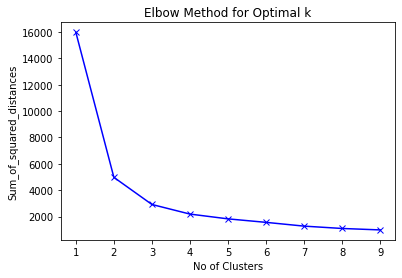

In [61]:
# using elbow graph to have an idea of which number of cluster would be a good fit

K = range(1,10)
Sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(df_scale)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [62]:
# Create a KMeans instance with 4 clusters: model
model = KMeans(n_clusters=4)

# Fit model to points
model.fit(df_scale.iloc[:,3:26])

# Determine the cluster labels of new_points: labels
df_scale['cluster'] = model.predict(df_scale.iloc[:,3:26])
df_scale.head()

,Date,State,Cases_White,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,...,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown,cluster
0,20200809,0,-0.956116,-0.706822,-0.366727,-0.491332,-0.080184,-0.096524,-0.251901,-0.585917,...,-0.352134,-0.174619,0.081557,-0.349348,-0.343455,-0.379823,-0.401038,-0.624676,-0.431885,2
1,20200809,1,0.399077,1.065248,-0.366727,-0.395721,-0.360325,-0.403107,-0.353838,0.063233,...,-0.345326,-0.301982,-0.375163,-0.349348,-0.205195,-0.085511,-0.360267,-0.191261,0.116450,2
2,20200809,2,0.158278,-0.007786,-0.366727,-0.283342,-0.278235,4.164777,-0.353838,0.208080,...,-0.331710,-0.273679,3.621143,-0.349348,-0.216717,-0.379823,-0.363403,-0.482026,-0.431885,2
3,20200809,3,-1.001632,-0.714647,-0.366727,-0.528079,-0.360325,-0.403107,-0.353838,-0.597459,...,-0.358942,-0.301982,-0.375163,-0.349348,-0.343455,-0.379823,-0.401038,-0.632568,-0.431885,2
4,20200809,4,0.561652,-0.411076,0.991137,0.042378,5.546180,-0.403107,-0.353838,-0.014899,...,-0.192145,6.504877,-0.375163,-0.349348,-0.074617,1.074850,0.531222,0.083113,0.834957,0


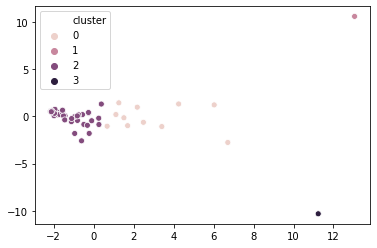

In [63]:
# Create PCA instance
model_pca = PCA()

pca_features = model_pca.fit_transform(df_scale.iloc[:,3:28])

# Assign 0th column of pca_features to xs
xs = pca_features[:,0]

# Assign 1st column of pca_features to ys
ys = pca_features[:,1]

# Scatter plot xs vs ys
sns.scatterplot(x=xs, y=ys, hue="cluster", data=df_scale)

In order to understand, explain and give a meaningful name we explore the centroids of each cluster.

In [64]:
centroids = model.cluster_centers_
df_scale.iloc[:,3:27].groupby(['cluster']).mean()

,Cases_Black,Cases_LatinX,Cases_Asian,Cases_AIAN,Cases_NHPI,Cases_Multiracial,Cases_Other,Cases_Unknown,Cases_Ethnicity_Hispanic,Cases_Ethnicity_NonHispanic,...,Deaths_LatinX,Deaths_Asian,Deaths_AIAN,Deaths_NHPI,Deaths_Multiracial,Deaths_Other,Deaths_Unknown,Deaths_Ethnicity_Hispanic,Deaths_Ethnicity_NonHispanic,Deaths_Ethnicity_Unknown
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.169837,0.543739,0.430239,0.238472,-0.228959,0.443041,0.449842,0.699791,0.513964,1.008241,...,0.561132,0.280086,0.366996,-0.146803,0.427405,0.320262,0.157483,0.591596,1.064423,0.275163
1,-0.714647,-0.366727,-0.528079,-0.360325,-0.403107,-0.353838,-0.597459,4.512445,-0.480055,-0.847799,...,4.854634,5.407477,-0.301982,-0.375163,-0.349348,6.727008,6.977976,4.868703,5.010629,5.975854
2,-0.290132,-0.265339,-0.248604,-0.055486,-0.023024,-0.164364,-0.225990,-0.325921,-0.255607,-0.314495,...,-0.332648,-0.286112,-0.092672,-0.072453,-0.171199,-0.241457,-0.209945,-0.340792,-0.411604,-0.213440
3,0.322137,5.795171,6.485431,0.123033,3.911691,2.548048,5.366777,1.804445,5.817534,3.280447,...,3.276773,3.814393,0.249925,5.105486,3.009439,0.132774,0.317359,3.277823,0.979688,0.175275


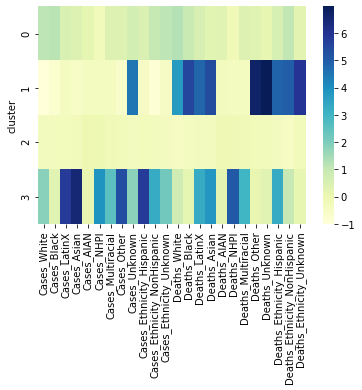

In [65]:
sns.heatmap(df_scale.iloc[:,2:27].groupby(['cluster']).mean(), cmap="YlGnBu")



* Cluster 0 has a small number of overall cases and deaths
* Cluster 2 has a bigger number of overall cases and deaths
* Cluster 3 has a big number of cases and deaths in other regions Cases mainly in unknown    and deaths in many such as Black and Ethnicity Hispanic
* Cluster 1 represents significant difference in number of cases and deaths of certain   Ethnicities and race as compared to the majority white population in US
* Higher number of corona cases for  Asians, NHPIs, Multiracial, Hispanics and other   Ethnicities
* Similarly higher number of deaths for Latinos, Hispanic, NHPI, Multiracial and Hispanics
  Ranging from scale of 3 and above
  

In [72]:
# printing the number of elements for each cluster

a = pd.DataFrame(df_scale['cluster'].value_counts(dropna=False))
print(a)


x = 0
maximum = 0
for i in range(4):
    if (maximum<a.cluster[i]):
        maximum = a.cluster[i]
        x = i
        
for i in range(len(df_scale['cluster'])): # printing states that are not in the main cluster
    if (df_scale['cluster'][i]!=x):
        print(main_data['State'][df_scale['State'][i]], df_scale['cluster'][i])
# maybe by looking at the states that are out of the main cluster, we can find some useful data

   cluster
2       43
0       11
3        1
1        1
AZ 0
CA 3
FL 0
GA 0
IL 0
LA 0
MA 0
MI 0
NJ 0
NY 1
OH 0
PA 0
TX 0


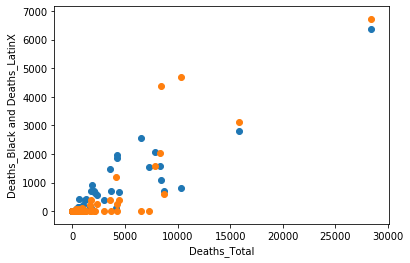

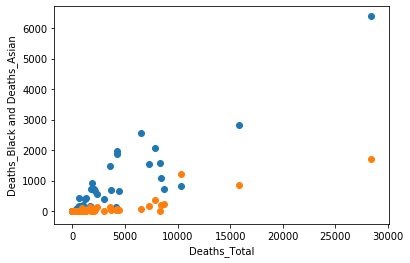

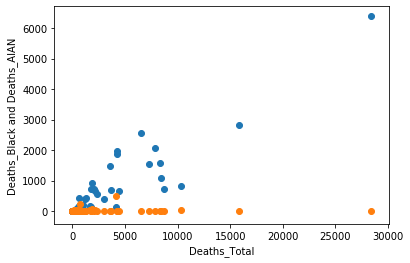

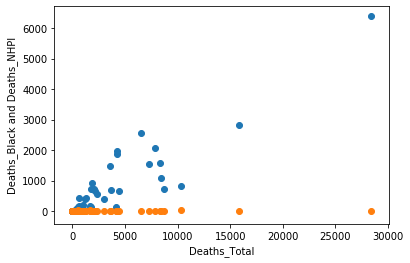

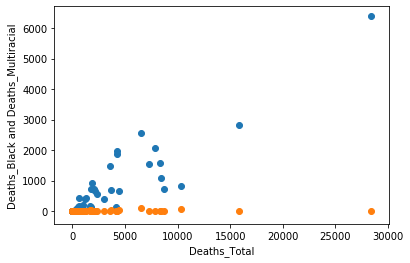

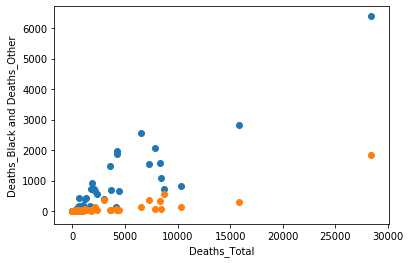

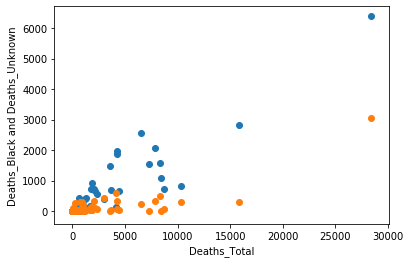

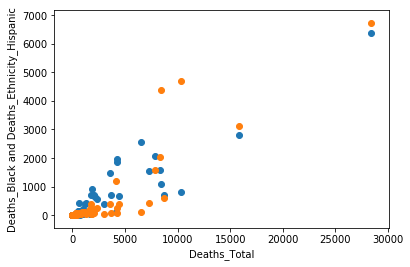

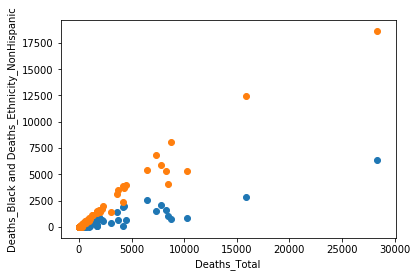

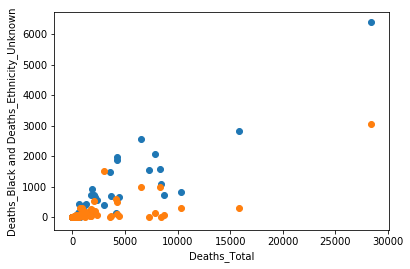

IndexError: index 24 is out of bounds for axis 0 with size 24

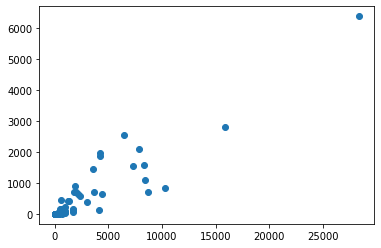

In [73]:
for i in range(13,26):
    for j in range(i+1,26):
        plt.scatter(df.Deaths_Total, df[columns[i]])
        plt.scatter(df.Deaths_Total, df[columns[j]])
        plt.xlabel('Deaths_Total')
        plt.ylabel(columns[i] + ' and '+ columns[j])
        plt.show()

In [ ]:
#sagemaker.Session().delete_endpoint()
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()